
**Target** : 
1.   Add Batch Normalization to increase model performance


**Results** : 
1.   Parameters: 7,852
2.   Best Training accuracy: 99.5%
1.   Best Testing accuracy: 99.21%

**Analysis**:
1.  Model is slightly overfitting; maybe its time for regularization 








In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) 
                                       
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                        transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0002)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


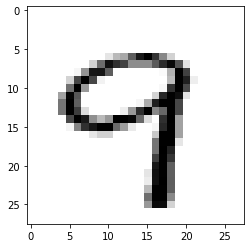

In [ ]:
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

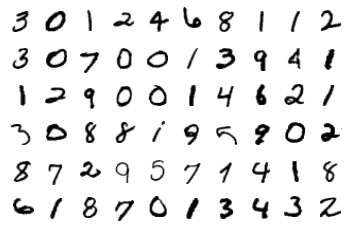

In [ ]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [ ]:
class MNISTNet(nn.Module):

  def __init__(self):
    super(MNISTNet, self).__init__()
    # Input Block
    self.convblock1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=1, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(8)
    ) # output_size = 28

    # CONVOLUTION BLOCK 1
    self.convblock2 = nn.Sequential(
        nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(16)
    ) # output_size = 26

    # TRANSITION BLOCK 1
    self.pool1 = nn.MaxPool2d(2, 2) # output_size = 13

    # CONVOLUTION BLOCK 1
    self.convblock3 = nn.Sequential(
        nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(16)
    ) # output_size = 11

    self.convblock4 = nn.Sequential(
        nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(16)
    ) # output_size = 9
    
    self.convblock5 = nn.Sequential(
        nn.Conv2d(in_channels=16, out_channels=14, kernel_size=(1, 1), padding=0, bias = False),
        nn.ReLU(),
        nn.BatchNorm2d(14)
    ) # output_size = 9

    
    self.convblock6 = nn.Sequential(
        nn.Conv2d(in_channels=14, out_channels=12, kernel_size=(3, 3), padding=0, bias = False),
        nn.ReLU(),
        nn.BatchNorm2d(12)
    ) # output_size = 7

    # OUTPUT BLOCK
    self.gap = nn.Sequential(
        nn.AvgPool2d(kernel_size=7)
    ) # output_size = 1

    self.convblock7 = nn.Sequential(
        nn.Conv2d(in_channels=12, out_channels=10, kernel_size=(1, 1), padding=0,  bias = False),
      ) # output_size = 1


  def forward(self, x):
    
    x = self.convblock1(x)
    x = self.convblock2(x)
    x = self.pool1(x)
    x = self.convblock3(x)
    
    x = self.convblock4(x)
    x = self.convblock5(x)
    x = self.convblock6(x)
    x = self.gap(x)
    x = self.convblock7(x)
    x = x.view(-1, 10)
    return F.log_softmax(x)

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = MNISTNet().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
              ReLU-2            [-1, 8, 28, 28]               0
       BatchNorm2d-3            [-1, 8, 28, 28]              16
            Conv2d-4           [-1, 16, 26, 26]           1,152
              ReLU-5           [-1, 16, 26, 26]               0
       BatchNorm2d-6           [-1, 16, 26, 26]              32
         MaxPool2d-7           [-1, 16, 13, 13]               0
            Conv2d-8           [-1, 16, 11, 11]           2,304
              ReLU-9           [-1, 16, 11, 11]               0
      BatchNorm2d-10           [-1, 16, 11, 11]              32
           Conv2d-11             [-1, 16, 9, 9]           2,304
             ReLU-12             [-1, 16, 9, 9]               0
      BatchNorm2d-13             [-1, 16, 9, 9]              32
           Conv2d-14             [

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:71: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
model =  MNISTNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:71: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.1386919766664505 Batch_id=468 Accuracy=83.68: 100%|██████████| 469/469 [00:11<00:00, 39.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1018, Accuracy: 9755/10000 (97.55%)

EPOCH: 1


Loss=0.09376350045204163 Batch_id=468 Accuracy=97.99: 100%|██████████| 469/469 [00:11<00:00, 39.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0797, Accuracy: 9767/10000 (97.67%)

EPOCH: 2


Loss=0.06909578293561935 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:11<00:00, 40.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0455, Accuracy: 9882/10000 (98.82%)

EPOCH: 3


Loss=0.050359830260276794 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:11<00:00, 40.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0462, Accuracy: 9850/10000 (98.50%)

EPOCH: 4


Loss=0.044897254556417465 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:12<00:00, 38.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0414, Accuracy: 9878/10000 (98.78%)

EPOCH: 5


Loss=0.04250696301460266 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:11<00:00, 39.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0335, Accuracy: 9907/10000 (99.07%)

EPOCH: 6


Loss=0.06277287006378174 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:11<00:00, 39.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0310, Accuracy: 9910/10000 (99.10%)

EPOCH: 7


Loss=0.025246070697903633 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:11<00:00, 39.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0306, Accuracy: 9916/10000 (99.16%)

EPOCH: 8


Loss=0.01793721131980419 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:11<00:00, 39.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Accuracy: 9923/10000 (99.23%)

EPOCH: 9


Loss=0.013638286851346493 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:11<00:00, 40.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0287, Accuracy: 9903/10000 (99.03%)

EPOCH: 10


Loss=0.0028513127472251654 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:11<00:00, 39.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0281, Accuracy: 9916/10000 (99.16%)

EPOCH: 11


Loss=0.002022596076130867 Batch_id=468 Accuracy=99.45: 100%|██████████| 469/469 [00:12<00:00, 39.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0264, Accuracy: 9919/10000 (99.19%)

EPOCH: 12


Loss=0.02037552371621132 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:11<00:00, 40.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0304, Accuracy: 9917/10000 (99.17%)

EPOCH: 13


Loss=0.0657242015004158 Batch_id=468 Accuracy=99.50: 100%|██████████| 469/469 [00:12<00:00, 38.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0266, Accuracy: 9921/10000 (99.21%)

EPOCH: 14


Loss=0.014556935988366604 Batch_id=468 Accuracy=99.52: 100%|██████████| 469/469 [00:11<00:00, 39.21it/s]



Test set: Average loss: 0.0344, Accuracy: 9899/10000 (98.99%)



Text(0.5, 1.0, 'Test Accuracy')

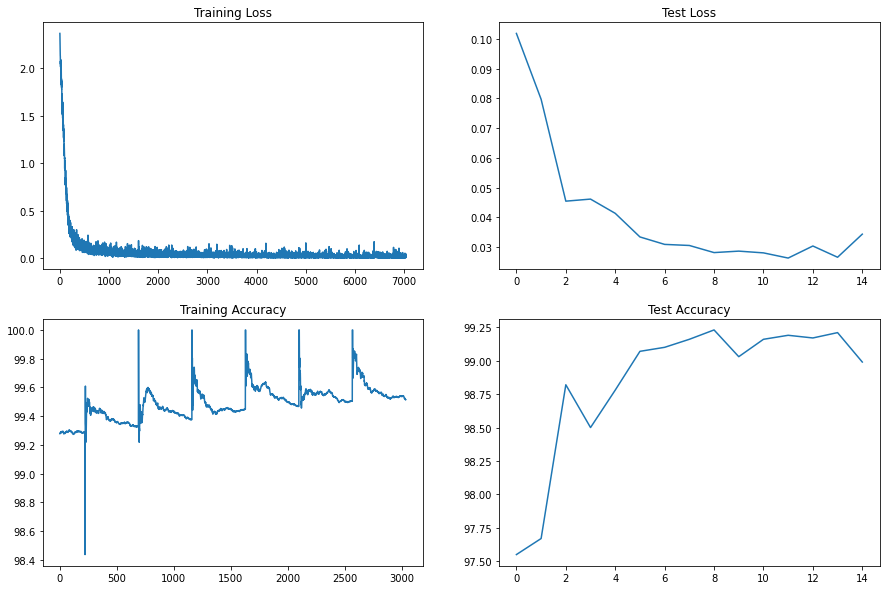

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")